In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
import dmm_gcp as gcp
import dmm_cp as cp
import palser as pals
import ntpoly as nt

# Note: using np.sum(A * B.T) for matrices A, B is equivalent to Trace(A^dag B)

converged SCF energy = -100.291327706251
TODO: total wave-function symmetry for Coov
occupancy for each irrep:     A1  E1x  E1y
                               3    1    1
**** MO energy ****
MO #1 (A1 #1), energy= -24.2331671128069 occ= 2
MO #2 (A1 #2), energy= -1.0272972299461 occ= 2
MO #3 (A1 #3), energy= -0.426131190105551 occ= 2
MO #4 (E1x #1), energy= -0.289938520612842 occ= 2
MO #5 (E1y #1), energy= -0.289938520612841 occ= 2
MO #6 (A1 #4), energy= -0.0349559135896365 occ= 0
MO #7 (A1 #5), energy= 0.664675049298746 occ= 0
MO #8 (E1x #2), energy= 1.1305709354121 occ= 0
MO #9 (E1y #2), energy= 1.1305709354121 occ= 0
MO #10 (A1 #6), energy= 1.24759809513673 occ= 0
MO #11 (A1 #7), energy= 1.57280313485608 occ= 0
 ** Mulliken atomic charges  **
charge of  0H =      0.35670
charge of  1F =     -0.35670
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000, -2.17040
Total dft energy: -100.29132770625064
Chemical Potential:  -0.16244721710123883
DFT trace:  7.1240097152571265
Core eigvals:  [

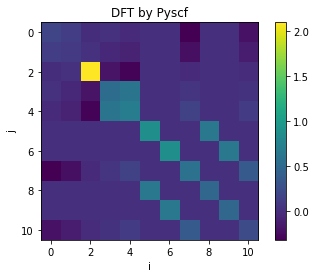

In [2]:
'''
A simple example to run DFT calculation.
'''

# PBE Hydrogen flouride in a 6-31G basis set.
mol = gto.Mole()
mol.build(
    atom = 'H 0 0 0; F 0 0 1.1',  # in Angstrom
    basis = '631g',
    symmetry = True,
)

mf = dft.RKS(mol)
#mf.xc = 'blyp' # shorthand for b88,lyp
mf.xc = 'pbe' # shorthand for pbe,pbe
#mf.xc = 'lda,vwn_rpa'
#mf.xc = 'pbe0'
#mf.xc = 'b3lyp'

# this where self-content diagonalization happens
mf.kernel()

# Orbital energies, Mulliken population etc.
mf.analyze()

# Get the converged density matrix (it generates the density matrix)
dm = mf.make_rdm1()
mmwrite('dft_density.mtx', sparse.coo_matrix(dm))


# Get the nuclear-nuclear repulsion energy
e_nuc = mf.energy_nuc()
# Get the 'core' hamiltonian, corresponding to kinetic energy and e-nuclear repulsion terms
h1e = mf.get_hcore()
#mmwrite('dft_hcore.mtx', sparse.coo_matrix(h1e))
e1 = np.einsum('ij,ji', h1e, dm) # Compute the kinetic + e-nuclear repulsion energy
# Get the kohn-sham potential, including the Hartree coulomb repulsion and exchange-correlation potential, integrated on a grid
vhf = mf.get_veff(mf.mol, dm)
#print(type(vhf))
#print(vhf)
# Total energy
tot_e = e1 + vhf.ecoul + vhf.exc + e_nuc    # Total energy is sum of terms
print('Total dft energy: {}'.format(tot_e))

# chemical potential
index = int(mol.nelectron/2)
mu = (mf.mo_energy[index] + mf.mo_energy[index - 1]) / 2.
dft_mu = mu
print('Chemical Potential: ', str(mu))

# get the overlap matrix and print to file
ovlp = mf.get_ovlp()
inv_ovlp = linalg.inv(ovlp)
#mmwrite('dft_overlap.mtx', sparse.coo_matrix(ovlp))

# Full fock matrix is sum of h1e and vhf
fock = h1e + vhf

# Get whole fock matrix directly corresponding to this density, without computing individual components
fock_direct = mf.get_fock(dm=dm)

# Check that ways to get the fock matrix are the same
assert(np.allclose(fock_direct,fock))

print("DFT trace: ", dm.trace())
print("Core eigvals: ", linalg.eigvalsh(h1e))
core_spect = linalg.eigvalsh(h1e)
num_electrons = 10
index = int(num_electrons/2)
our_mu = (core_spect[index] + core_spect[index-1])/2

plt.imshow(dm.real)
plt.title("DFT by Pyscf")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

NTPoly Trace:  4.015391362234546


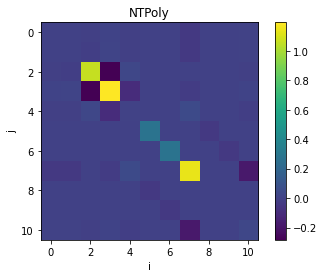

In [3]:
ntpoly_rho = nt.NTPoly_cp(h1e, ovlp, int(dm.trace()))
print("NTPoly Trace: ", ntpoly_rho.trace())

plt.imshow(ntpoly_rho.real)
plt.title("NTPoly")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

GCP steps:  14
Palser GCP trace:  (4.999999999999999+0j)
CP steps:  22
Palser CP trace:  (7.124009715257122+0j)


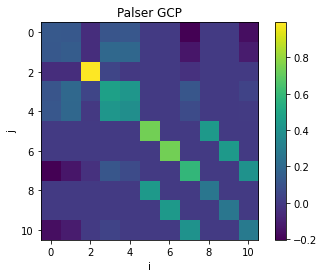

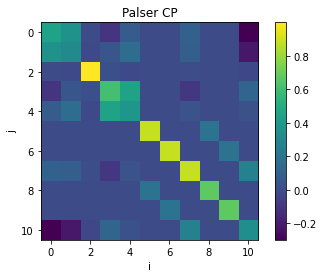

In [4]:
# Palser solver
mu = our_mu
palser_gcp_rho = pals.gcp(mu, h1e, 1000)
print("Palser GCP trace: ", palser_gcp_rho.trace())
palser_cp_rho = pals.cp(dm.trace(), h1e, 1000)
print("Palser CP trace: ", palser_cp_rho.trace())

plt.figure(1)
plt.imshow(palser_gcp_rho.real)
plt.title("Palser GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.imshow(palser_cp_rho.real)
plt.title("Palser CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

DMM GCP trace:  5.754093965067293
DMM CP trace:  10.000000000000009
funm result may be inaccurate, approximate err = 1


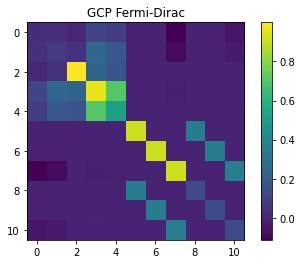

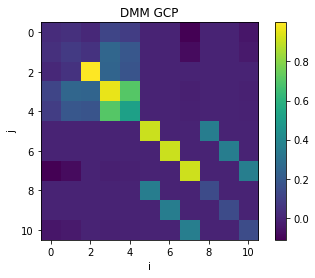

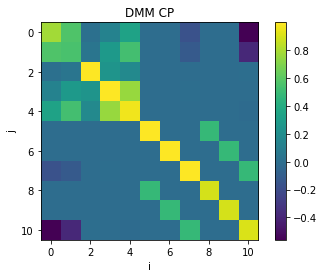

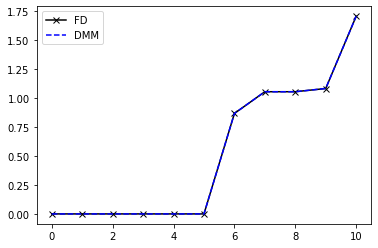

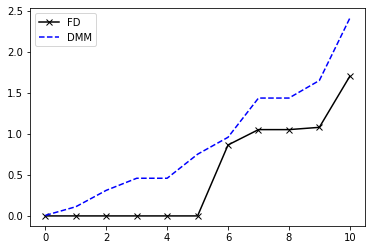

In [5]:
# DMM Solvers
dbeta = 0.003
num_electrons = 10

inv_ovlp = np.linalg.inv(ovlp)
gcp_init_rho = ovlp/2
identity = np.identity(gcp_init_rho.shape[0])

dmm_gcp = gcp.rk4(gcp.rhs, gcp_init_rho.copy(), dbeta, h1e, inv_ovlp, identity, mu, 1000)
print("DMM GCP trace: ", dmm_gcp.trace())

cp_init_rho = num_electrons/ovlp.trace() * ovlp
dmm_cp = cp.rk4(cp.rhs, cp_init_rho.copy(), dbeta, h1e, inv_ovlp, identity, 1000)
print("DMM CP trace: ", dmm_cp.trace())

gcp_fermi = ovlp @ linalg.funm(inv_ovlp @ h1e, lambda _: 1/(1+np.exp(1000*dbeta*(_ - mu))))
plt.figure(1)
plt.imshow(gcp_fermi)
plt.title("GCP Fermi-Dirac")
plt.colorbar()

plt.figure(2)
plt.imshow(dmm_gcp.real)
plt.title("DMM GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(3)
plt.imshow(dmm_cp.real)
plt.title("DMM CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(4)
plt.plot(linalg.eigvalsh(gcp_fermi), 'kx-', label="FD")
#plt.plot(linalg.eigvalsh(palser_gcp_rho), 'r-', label="Palser GCP")
plt.plot(linalg.eigvalsh(dmm_gcp), 'b--', label="DMM")
#plt.plot(linalg.eigvalsh(dm), 'g:', label="DFT")
plt.legend(numpoints=1)

plt.figure(5)
plt.plot(linalg.eigvalsh(gcp_fermi), 'kx-', label="FD")
#plt.plot(linalg.eigvalsh(palser_cp_rho), 'r-', label="Palser GCP")
plt.plot(linalg.eigvalsh(dmm_cp), 'b--', label="DMM")
#plt.plot(linalg.eigvalsh(dm), 'g:', label="DFT")
plt.legend(numpoints=1)

funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 2.8172362418962642e-11
funm result may be inaccurate, approximate err = 6.76303373052345e-11
funm result may be inaccurate, approximate err = 9.047911485628338e-09
funm result may be inaccurate, approximate err = 5.226410595610075e-09
funm result may be inaccurate, approximate err = 7.264737327523826e-07
funm result may be inaccurate, approximate err = 1.2012618534963681e-08
funm result may be inaccurate, approximate err = 1.6625340183042965e-06
funm result may be inaccurate, approximate err = 8.135433488249105e-05
funm result may be inaccurate, approximate err = 0.011472736368052306
funm result may be inaccurate, approximate err = 0.0004186073779215491
funm result may be inaccurate, app

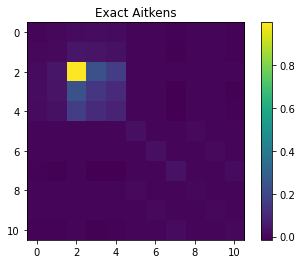

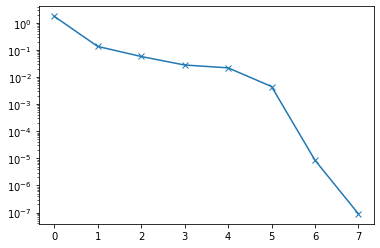

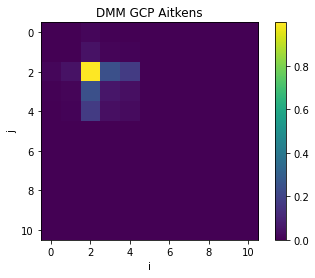

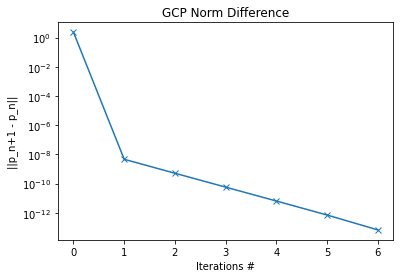

In [6]:
# Perform Aitkens convergence method on DMM methods
# First get the exact by Fermi-Dirac
func_args = {'h1e': h1e, 'mf': mf, 'mu': mu, 'ovlp':ovlp, 'inv_ovlp': inv_ovlp, 'beta': dbeta*1000}
exact_fd, norm_diff = gcp.aitkens(gcp_init_rho, 50, gcp.exact_single_step, **func_args)
plt.figure(1)
plt.imshow(exact_fd)
plt.title("Exact Aitkens")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, 'x-')

func_args = {'h1e': h1e, 'mf': mf, 'mu': mu, 'inv_ovlp': inv_ovlp, 'dbeta': dbeta, 'rk4steps': 1000}
gcp_aitkens_rho, norm_diff = gcp.aitkens(dmm_gcp, 50, gcp.single_step, **func_args)

plt.figure(3)
plt.imshow(gcp_aitkens_rho)
plt.title("DMM GCP Aitkens")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(4)
plt.semilogy(norm_diff, 'x-')
plt.title("GCP Norm Difference")
plt.xlabel("Iterations #")
plt.ylabel("||p_n+1 - p_n||")

func_args = {'h1e': h1e, 'mf': mf, 'inv_ovlp': inv_ovlp, 'dbeta': dbeta, 'rk4steps': 1000}
cp_aitkens_rho, norm_diff = gcp.aitkens(dmm_cp, 20, cp.single_step, **func_args)

funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.9463143224078409
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 3.977363367752727e-09
funm result may be inaccurate, approximate err = 2.7570318916803982e-11
funm result may be inaccurate, approximate err = 9.433427204058203e-10
funm result may be inaccurate, approximate err = 1.1900032190364885e-09
funm result may be inaccurate, approximate err = 3.977685795294525e-08
funm result may be inaccurate, approximate err = 1.3399070818843598e-09
funm result may be inaccurate, approximate err = 7.017169446118757e-08
funm result may be inaccurate, approximate err = 1.558601667647812e-08
funm result may be inaccurate, approximate err = 3.9212

Text(0, 0.5, '||p_n+1 - p_n||')

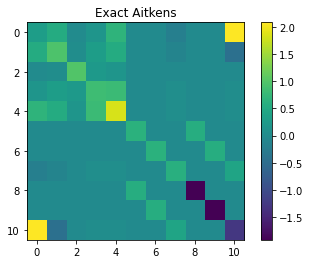

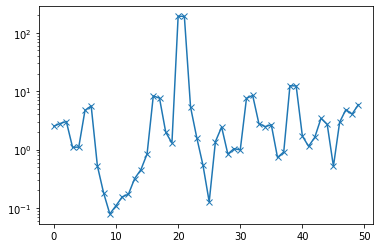

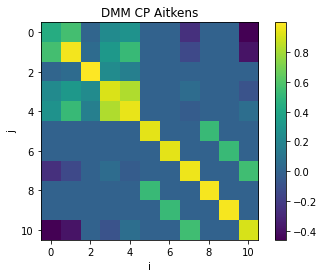

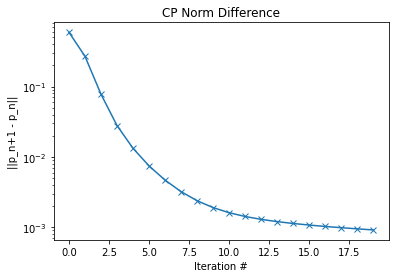

In [7]:
func_args = {'h1e': h1e, 'mf': mf, 'mu': mu, 'ovlp':ovlp, 'inv_ovlp': inv_ovlp, 'beta': dbeta*1000}
exact_fd, norm_diff = gcp.aitkens(cp_init_rho, 50, cp.exact_single_step, **func_args)
plt.figure(1)
plt.imshow(exact_fd)
plt.title("Exact Aitkens")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, 'x-')

func_args = {'h1e': h1e, 'mf': mf, 'inv_ovlp': inv_ovlp, 'dbeta': dbeta, 'rk4steps': 1000}
cp_aitkens_rho, norm_diff = gcp.aitkens(dmm_cp, 20, cp.single_step, **func_args)

plt.figure(3)
plt.imshow(cp_aitkens_rho)
plt.title("DMM CP Aitkens")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(4)
plt.semilogy(norm_diff, 'x-')
plt.title("CP Norm Difference")
plt.xlabel("Iteration #")
plt.ylabel("||p_n+1 - p_n||")

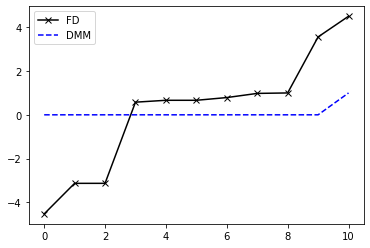

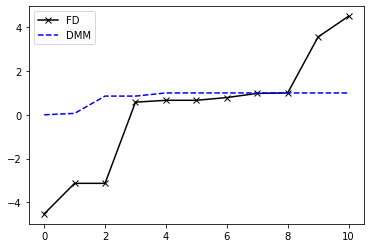

In [8]:
plt.figure(1)
plt.plot(linalg.eigvalsh(exact_fd, ovlp), 'kx-', label="FD")
#plt.plot(linalg.eigvalsh(palser_gcp_rho), 'r-', label="Palser GCP")
plt.plot(linalg.eigvalsh(gcp_aitkens_rho, ovlp), 'b--', label="DMM")
#plt.plot(linalg.eigvalsh(dm, ovlp), 'g:', label="DFT")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(linalg.eigvalsh(exact_fd, ovlp), 'kx-', label="FD")
#plt.plot(linalg.eigvalsh(palser_cp_rho), 'r-', label="Palser GCP")
plt.plot(linalg.eigvalsh(cp_aitkens_rho, ovlp), 'b--', label="DMM")
#plt.plot(linalg.eigvalsh(dm, ovlp), 'g:', label="DFT")
plt.legend(numpoints=1)

funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.9542469470676407
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.9472260027888347
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.7634163940804379
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
Iterations converged!
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.6352376506445898
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate 

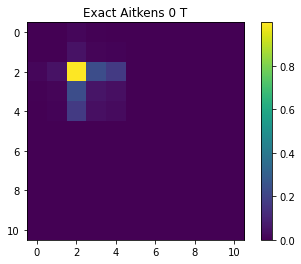

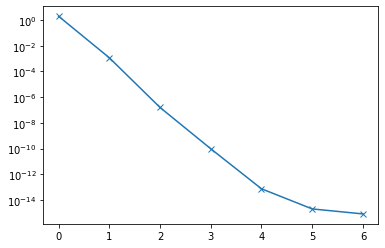

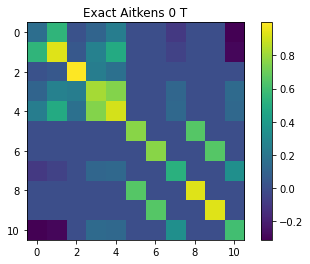

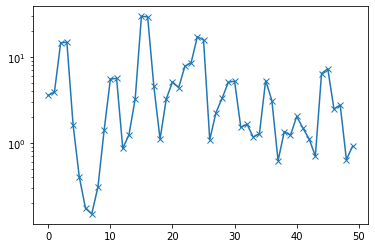

In [9]:
# Steady State solutions
# first exact by heaviside
func_args = {'h1e': h1e, 'mf': mf, 'mu': mu, 'ovlp':ovlp, 'inv_ovlp': inv_ovlp}
gcp_exact_hv, norm_diff = gcp.aitkens(gcp_init_rho, 50, gcp.exact0_single_step, **func_args)

plt.figure(1)
plt.imshow(gcp_exact_hv)
plt.title("Exact Aitkens 0 T")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, 'x-')

cp_exact_hv, norm_diff = gcp.aitkens(cp_init_rho, 50, cp.exact0_single_step, **func_args)

plt.figure(3)
plt.imshow(cp_exact_hv)
plt.title("Exact Aitkens 0 T")
plt.colorbar()

plt.figure(4)
plt.semilogy(norm_diff, 'x-')

In [10]:
print(gcp_exact_hv.trace())
print(cp_exact_hv.trace())

1.0876279961074564
8.360526384666597


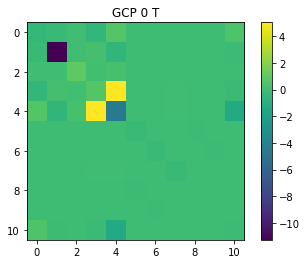

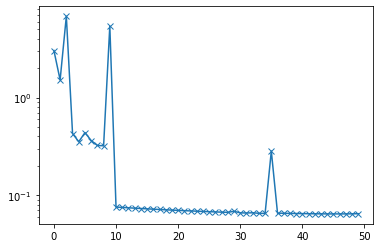

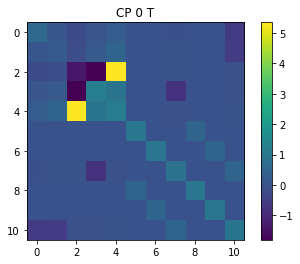

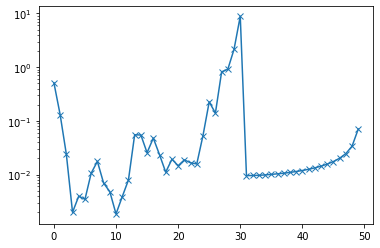

In [11]:
func_args = {'h1e': h1e, 'mf': mf, 'mu': mu, 'ovlp':ovlp, 'inv_ovlp': inv_ovlp}
gcp_steady, norm_diff = gcp.aitkens(gcp_init_rho, 50, gcp.steady_single_step, **func_args)

plt.figure(1)
plt.imshow(gcp_steady)
plt.title("GCP 0 T")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, 'x-')

func_args = {'h1e': h1e, 'mf': mf, 'mu': mu, 'ovlp':ovlp, 'inv_ovlp': inv_ovlp}
cp_steady, norm_diff = gcp.aitkens(cp_init_rho, 50, gcp.steady_single_step, **func_args)

plt.figure(3)
plt.imshow(cp_steady)
plt.title("CP 0 T")
plt.colorbar()

plt.figure(4)
plt.semilogy(norm_diff, 'x-')